In [16]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [17]:
#Set Parameters
im_width = 256
im_height = 256

In [18]:
train_files = []
mask_files = glob('../input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask',''))

print(train_files[:10])
print(mask_files[:10])

['../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_17.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_4.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_11.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_19.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_21.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_18.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_9.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_22.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_10.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_1.tif']
['../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6669_2002010

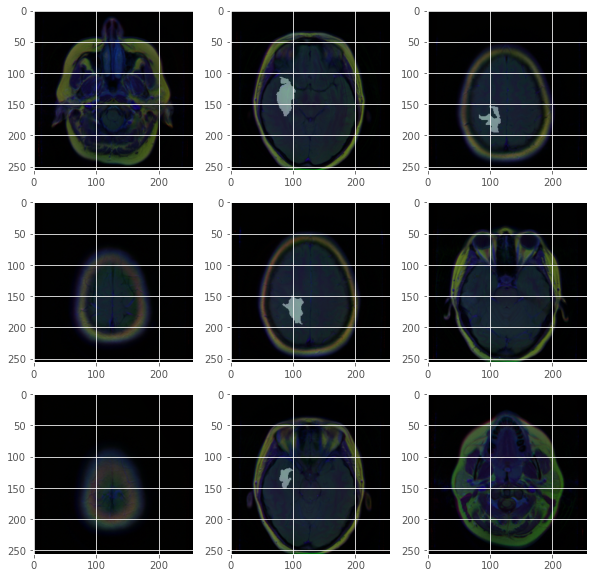

In [19]:
#Lets plot some samples
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=train_files[i]
    msk_path=mask_files[i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)
    plt.imshow(img)
    plt.imshow(msk,alpha=0.4)
plt.show()

In [20]:
df = pd.DataFrame(data={"filename": train_files, 'mask' : mask_files})
df_train, df_test = train_test_split(df,test_size = 0.1)
df_train, df_val = train_test_split(df_train,test_size = 0.2)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2828, 2)
(708, 2)
(393, 2)


In [21]:
# From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [22]:
smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

In [23]:
def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [24]:
model = unet()
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 256, 256, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
activation_36 (Activation)      (None, 256, 256, 64) 0           conv2d_38[0][0]                  
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 256, 256, 64) 36928       activation_36[0][0]              
_______________________________________________________________________________________

In [25]:
EPOCHS = 50
BATCH_SIZE = 32
learning_rate = 1e-4

In [26]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))
    
test_gener = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
    
model = unet(input_size=(im_height, im_width, 3))



decay_rate = learning_rate / EPOCHS
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
model.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

callbacks = [ModelCheckpoint('unet_brain_mri_seg.hdf5', verbose=1, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=len(df_val) / BATCH_SIZE)

Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/50
89/88 [==============================] - ETA: 0s - loss: -0.0784 - binary_accuracy: 0.8720 - iou: 0.0414 - dice_coef: 0.0788Found 708 validated image filenames.
Found 708 validated image filenames.

Epoch 00001: val_loss improved from inf to -0.02480, saving model to unet_brain_mri_seg.hdf5
89/88 [==============================] - 107s 1s/step - loss: -0.0784 - binary_accuracy: 0.8720 - iou: 0.0414 - dice_coef: 0.0788 - val_loss: -0.0248 - val_binary_accuracy: 0.9870 - val_iou: 0.0125 - val_dice_coef: 0.0244
Epoch 2/50
89/88 [==============================] - ETA: 0s - loss: -0.1311 - binary_accuracy: 0.9746 - iou: 0.0711 - dice_coef: 0.1315
Epoch 00002: val_loss improved from -0.02480 to -0.06749, saving model to unet_brain_mri_seg.hdf5
89/88 [==============================] - 101s 1s/step - loss: -0.1311 - binary_accuracy: 0.9746 - iou: 0.0711 - dice_coef: 0.1315 - val_loss: -0.0675 - val_binary_ac

89/88 [==============================] - ETA: 0s - loss: -0.7768 - binary_accuracy: 0.9968 - iou: 0.6430 - dice_coef: 0.7768
Epoch 00019: val_loss improved from -0.77699 to -0.77988, saving model to unet_brain_mri_seg.hdf5
89/88 [==============================] - 100s 1s/step - loss: -0.7768 - binary_accuracy: 0.9968 - iou: 0.6430 - dice_coef: 0.7768 - val_loss: -0.7799 - val_binary_accuracy: 0.9966 - val_iou: 0.6421 - val_dice_coef: 0.7792
Epoch 20/50
89/88 [==============================] - ETA: 0s - loss: -0.7771 - binary_accuracy: 0.9967 - iou: 0.6408 - dice_coef: 0.7767
Epoch 00020: val_loss did not improve from -0.77988
89/88 [==============================] - 98s 1s/step - loss: -0.7771 - binary_accuracy: 0.9967 - iou: 0.6408 - dice_coef: 0.7767 - val_loss: -0.7345 - val_binary_accuracy: 0.9962 - val_iou: 0.5941 - val_dice_coef: 0.7367
Epoch 21/50
89/88 [==============================] - ETA: 0s - loss: -0.7927 - binary_accuracy: 0.9970 - iou: 0.6626 - dice_coef: 0.7924
Epoch 00

89/88 [==============================] - ETA: 0s - loss: -0.8616 - binary_accuracy: 0.9975 - iou: 0.7623 - dice_coef: 0.8616
Epoch 00038: val_loss did not improve from -0.87611
89/88 [==============================] - 97s 1s/step - loss: -0.8616 - binary_accuracy: 0.9975 - iou: 0.7623 - dice_coef: 0.8616 - val_loss: -0.8685 - val_binary_accuracy: 0.9975 - val_iou: 0.7699 - val_dice_coef: 0.8684
Epoch 39/50
89/88 [==============================] - ETA: 0s - loss: -0.8446 - binary_accuracy: 0.9974 - iou: 0.7409 - dice_coef: 0.8445
Epoch 00039: val_loss did not improve from -0.87611
89/88 [==============================] - 96s 1s/step - loss: -0.8446 - binary_accuracy: 0.9974 - iou: 0.7409 - dice_coef: 0.8445 - val_loss: -0.8558 - val_binary_accuracy: 0.9972 - val_iou: 0.7526 - val_dice_coef: 0.8524
Epoch 40/50
89/88 [==============================] - ETA: 0s - loss: -0.8577 - binary_accuracy: 0.9974 - iou: 0.7564 - dice_coef: 0.8580
Epoch 00040: val_loss did not improve from -0.87611
89/

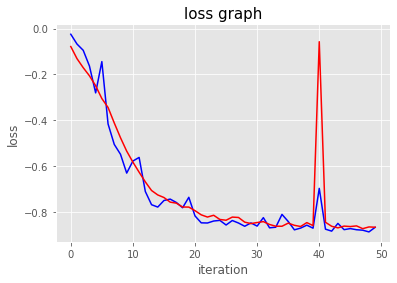

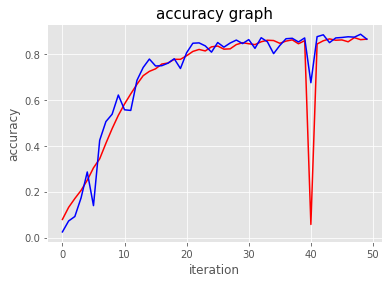

In [27]:
a = history.history

list_traindice = a['dice_coef']
list_testdice = a['val_dice_coef']

list_trainjaccard = a['iou']
list_testjaccard = a['val_iou']

list_trainloss = a['loss']
list_testloss = a['val_loss']
plt.figure(1)
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.figure(2)
plt.plot(list_traindice, 'r-')
plt.plot(list_testdice, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.show()

In [28]:
model = load_model('unet_brain_mri_seg.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})

In [29]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test lost: ",results[0])
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

Found 393 validated image filenames.
Found 393 validated image filenames.
13/12 [===============================] - 3s 264ms/step - loss: -0.8718 - binary_accuracy: 0.9973 - iou: 0.7739 - dice_coef: 0.8712
Test lost:  -0.8717833161354065
Test IOU:  0.9973216652870178
Test Dice Coefficent:  0.7738600969314575


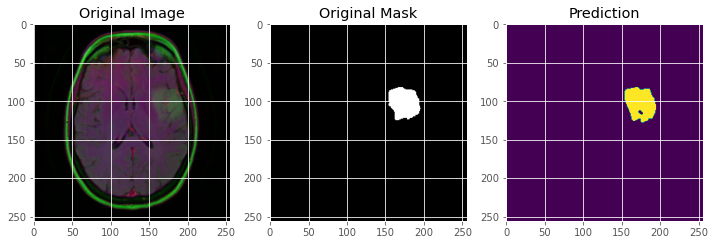

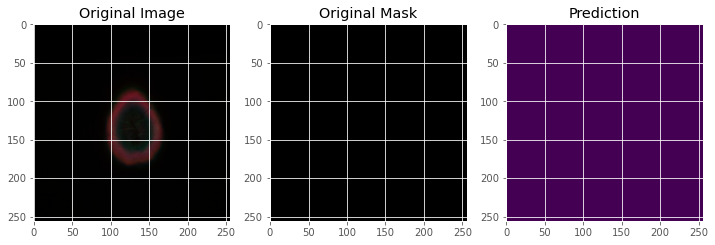

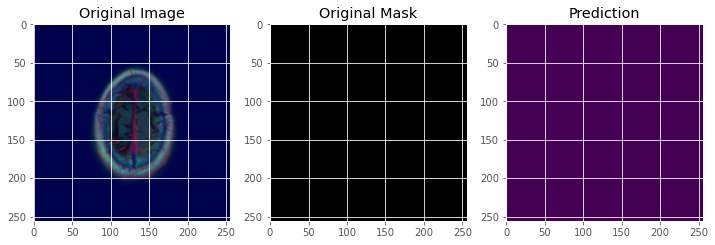

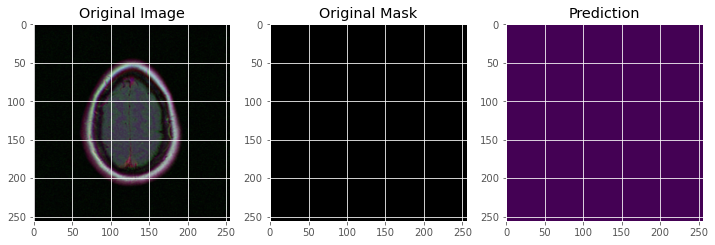

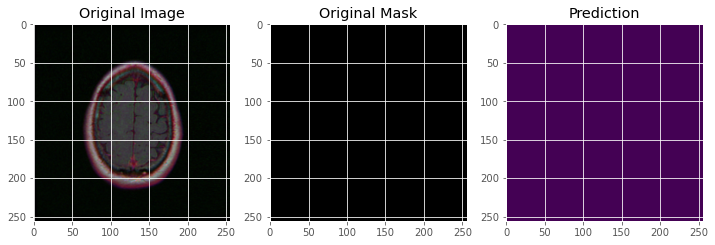

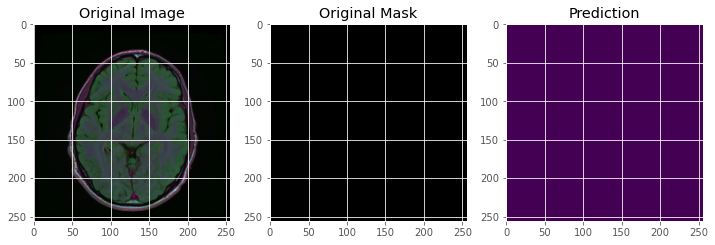

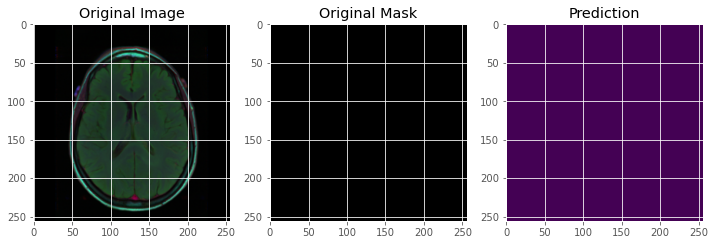

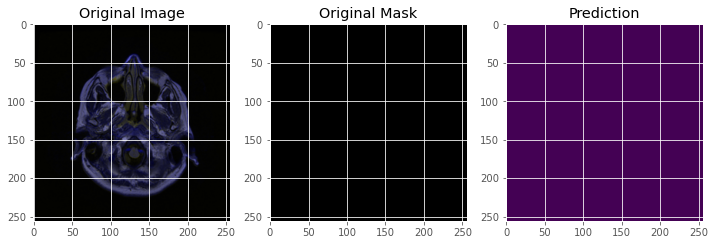

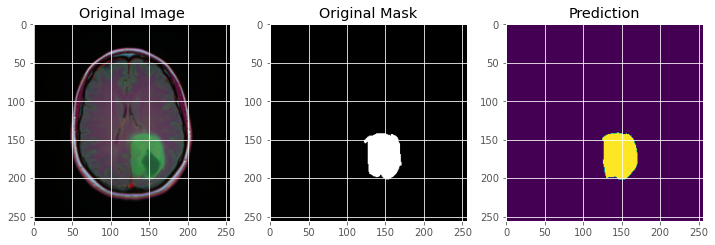

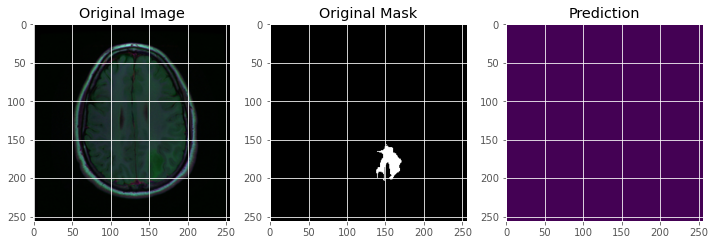

In [ ]:
for i in range(30):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['filename'].iloc[index])
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()